In [1]:
import numpy as np
import pandas as pd

# Web Scraping libraries
import requests 
from bs4 import BeautifulSoup 

# Spotify libraries and config file
import config
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

# Scale Data and model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
%matplotlib inline
import pickle
from sklearn.metrics import silhouette_score

# song recommender
import random as rd

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Embedded track player

In [2]:
from IPython.display import IFrame

#track_id = "1rfORa9iYmocEsnnZGMVC4"
track_id= 'spotify:track:3hgl7EQwTutSm6PESsB7gZ'
IFrame(src="https://open.spotify.com/embed/track/"+track_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

def play_song(track_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+track_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

### Collect a diverse range of spotify playlists

#### Let's try this with webscraping...

#download the webpage 
url = "https://audiohype.io/resources/the-best-spotify-playlists/" 
page = requests.get(url)
page.status_code # this should return 200, meaning that all went ok.

# parse the html 
soup = BeautifulSoup(page.content, 'html.parser') 

# print the formatted html 
#print(soup.prettify())

title = []
ids = []
for i in range(len(soup.select("h3 a"))):
    title.append(soup.select("h3 a")[i].get_text())
    ids.append(soup.select("h3 a")[i]["href"].strip("https://open.spotify.com/playlist/").split("?")[0])

df_pl = pd.DataFrame(np.array([title,ids]).transpose(), columns=["playlist","id"])
df_pl

def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id,market="GB")
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

track_ids = []
for pl in range(len(df_pl.playlist)):
    x = get_playlist_tracks("spotify", df_pl.id[pl])
    for tr in range(len(x)):
        if type(x[tr]["track"]) is not type(None):
            track_ids.append(x[tr]["track"]["id"])

### Extract audio features

song_lst = []

print("start at track #",len(song_lst)-1)
for idx in range(len(song_lst)-1,len(tracks)):
    if (idx/300) in [range(0,100)]: print(idx)
    if type(sp.audio_features(tracks[idx])) is not type(None) and type(sp.audio_features(tracks[idx])[0]) is not type(None):
        song_lst.append(sp.audio_features(tracks[idx])[0])
df = pd.DataFrame(song_lst)
df = df[["danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo","id","duration_ms"]]
df

df = df.drop_duplicates()
audio_features = df.drop(columns="id")

df.to_csv("data/df.csv", index=False)

audio_features.to_csv("data/audio_features.csv", index=False)

In [3]:
af = pd.read_csv("data/audio_features.csv")

In [4]:
df = pd.read_csv("data/df.csv")

### Choose audio features

In [5]:
audio_features = af[['energy','instrumentalness','liveness']]

### Scale data

In [6]:
scaler = StandardScaler()
scaler.fit(audio_features)
audio_features_scaled = scaler.transform(audio_features)
pd.DataFrame(audio_features_scaled)

,0,1,2
0,-0.047661,-0.866983,-0.256581
1,-0.670865,-0.866976,0.625953
2,0.119985,-0.866963,-0.770443
3,0.273053,-0.864397,0.946227
4,0.546388,-0.865272,-0.455863
...,...,...,...
4714,1.023813,-0.866988,-0.746956
4715,0.772345,-0.866984,3.508421
4716,0.757767,-0.866988,-0.391808
4717,1.027458,-0.784645,-0.583261


### K-means clustering

In [7]:
kmeans = KMeans(n_clusters=7, random_state=1234)
kmeans.fit(audio_features_scaled)
# assign a cluster to each example
labels = kmeans.predict(audio_features_scaled)
# retrieve unique clusters
clusters = np.unique(labels)
pd.Series(labels).value_counts().sort_index()

0    1433
1     791
2     233
3     742
4     733
5     170
6     617
dtype: int64

#### create scatter plot for samples from each cluster

for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(audio_features.to_numpy()[row_ix, 0], audio_features.to_numpy()[row_ix,2])
    pyplot.xlabel("liveliness")
    pyplot.ylabel("energy")
    # show the plot
pyplot.show()

#### create scatter plot for samples from each cluster

for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(audio_features.to_numpy()[row_ix, 1], audio_features.to_numpy()[row_ix, 2])
    # show the plot
pyplot.show()

In [8]:
df_labeled = df
df_labeled["cluster"] = labels
df_labeled

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,cluster
0,0.637,0.643,-6.571,0.0519,0.13000,0.000002,0.1420,0.533,97.008,0V3wPSX9ygBnCm8psDIegu,200690,0
1,0.714,0.472,-7.375,0.0864,0.01300,0.000005,0.2660,0.238,131.121,3nqQXoyQOWXiESFLlDF1hG,156943,3
2,0.780,0.689,-5.668,0.1410,0.03680,0.000010,0.0698,0.642,115.042,1xzi1Jcr7mEi9K2RfzLOqS,225389,0
3,0.520,0.731,-5.338,0.0557,0.34200,0.001010,0.3110,0.662,173.930,4LRPiXqCikLlN15c3yImP7,167303,6
4,0.801,0.806,-5.206,0.0381,0.38200,0.000669,0.1140,0.802,106.999,0WtM2NBVQNNJLh6scP13H8,239318,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4714,0.714,0.937,-2.947,0.0399,0.20600,0.000000,0.0731,0.964,124.130,5EOoMWIB9iK4ZpcSex9Ec7,194147,0
4715,0.616,0.868,-3.606,0.0699,0.00131,0.000002,0.6710,0.475,108.016,3Te8uLyit6X3ncNW8Fp3K2,189387,5
4716,0.640,0.864,-6.576,0.0314,0.00832,0.000000,0.1230,0.701,102.026,42et6fnHCw1HIPSrdPprMl,268360,0
4717,0.324,0.938,-7.332,0.1020,0.03200,0.032100,0.0961,0.543,168.131,0Puj4YlTm6xNzDDADXHMI9,178440,0


### Chosing k

#### Elbow method

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

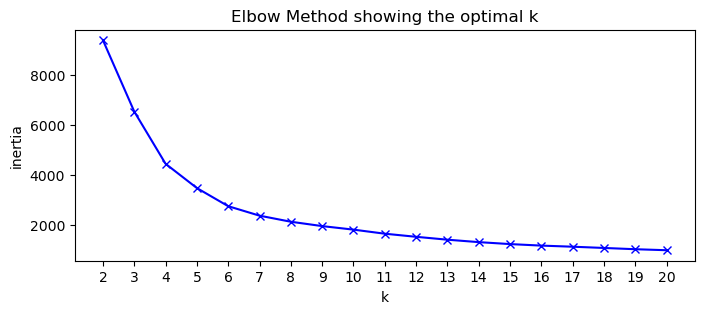

In [9]:
import matplotlib.pyplot as plt

K = range(2, 21)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(audio_features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,3))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

#### Silhouette Score

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

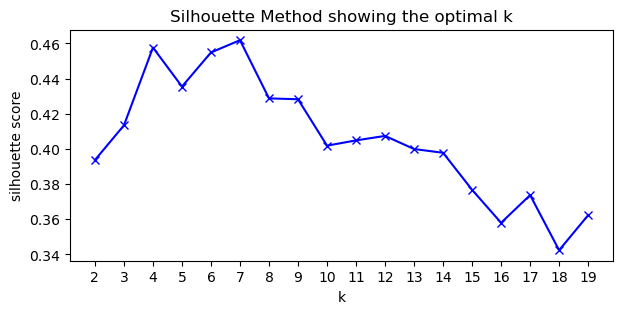

In [10]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(audio_features_scaled)
    
    filename = "model/kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(audio_features_scaled, kmeans.predict(audio_features_scaled)))


plt.figure(figsize=(7,3))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

### Song Recommender

In [11]:
def song_input():
    song_input = input("Choose a song, please: ")
    return song_input

def get_song_id():
    user_song_name =  song_input()
    user_song = sp.search(q=user_song_name,limit=10, market="DE")
    user_song_id = user_song["tracks"]["items"][0]["id"]
    return user_song_id

In [16]:
song = get_song_id()
afs = sp.audio_features(song)
afs = pd.DataFrame(afs)
afs = afs[['energy','instrumentalness','liveness']]
play_song(song)

Choose a song, please: air I breathe


In [17]:
user_input_transformed = scaler.transform(afs)
user_input_transformed_df = pd.DataFrame(user_input_transformed, columns = ['energy','instrumentalness','liveness'])
print(user_input_transformed_df)
print("-----------------------------------------")
kmeans = KMeans(n_clusters=7, random_state=1234)
kmeans.fit(audio_features_scaled)
# assign a cluster to each example
labels = kmeans.predict(audio_features_scaled)
# retrieve unique clusters
clusters = np.unique(labels)
print(pd.DataFrame(labels).value_counts().sort_index())
user_cluster = kmeans.predict(user_input_transformed_df)[0]
print("-------------------------------")
print("The song belongs to cluster",user_cluster)
print("Another song we recommend based on your choice is...")
idx_recommended_song = rd.choice(df_labeled[df_labeled.cluster==user_cluster].index)
id_rs = df_labeled.id[idx_recommended_song]
play_song(id_rs)

     energy  instrumentalness  liveness
0  0.987368           -0.8488 -0.064416
-----------------------------------------
0    1433
1     791
2     233
3     742
4     733
5     170
6     617
dtype: int64
-------------------------------
The song belongs to cluster 0
Another song we recommend based on your choice is...
